# Model Comparisons in Demand Forecasting for E-Commerce

**Objective:** an ecommerce platform aimed to predict customer demand to optimize pricing and inventory management.

**Approach:** time series data of customer browsing behavior, product views, and historical sales were collected. Multiple models were used to capture seasonality and long-term dependencies.

**Outcome:** accurate demand forecasts helped the e-commerce platform optimize pricing, improve product recommendations, and efficiently manage inventory, resulting in increased sales and customer retention.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [43]:
# Load the data
data = pd.read_csv('../data_sets/demand.csv')

In [44]:
# Convert the 'week' column into datetime format
data['week'] = pd.to_datetime(data['week'], format='%d/%m/%y')
data.set_index('week', inplace=True)

# Aggregate the data by week
weekly_data = data['units_sold'].resample('W').sum()

In [45]:
# Train - Test Split
# train_data = weekly_data[:int(0.8*(len(weekly_data)))]
# test_data = weekly_data[int(0.8*(len(weekly_data))):]

from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data = weekly_data[:int(0.8*(len(weekly_data)))]
test_data = weekly_data[int(0.8*(len(weekly_data))):]

## Models

### Holt-Winters model

In [46]:
# Fit
hw_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=52).fit()

# Predict
hw_predictions = hw_model.predict(start=test_data.index[0], end=test_data.index[-1])

### ARIMA

In [47]:
# Fit
arima_model = ARIMA(train_data, order=(1, 0, 0)).fit()
# using (1,0,0) from autocorrelation test. can also use grid search

# Predict
arima_predictions = arima_model.predict(start=test_data.index[0], end=test_data.index[-1])

### Facebook Prophet

In [48]:
# Prepare the data for Prophet
prophet_data = weekly_data.reset_index()
prophet_data.columns = ['ds', 'y']

# Split the data into train and test sets
train_data_prophet = prophet_data[:int(0.8*(len(prophet_data)))]
test_data_prophet = prophet_data[int(0.8*(len(prophet_data))):]

# Fit
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(train_data_prophet)

# Predict
prophet_future = prophet_model.make_future_dataframe(periods=len(test_data))
prophet_predictions = prophet_model.predict(prophet_future)

21:16:04 - cmdstanpy - INFO - Chain [1] start processing
21:16:04 - cmdstanpy - INFO - Chain [1] done processing


## Calculate RMSE for each model

In [49]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# --- Align Prophet predictions to test window ---
# prophet_predictions is the full forecast df from model.predict(future)
prophet_yhat_test = prophet_predictions['yhat'].iloc[-len(test_data_prophet):].to_numpy()
prophet_y_test    = test_data_prophet['y'].to_numpy()

# --- Compute RMSEs ---
rmses = {
    "Holt-Winters": rmse(test_data, hw_predictions),
    "ARIMA":        rmse(test_data, arima_predictions),
    "Prophet":      rmse(prophet_y_test, prophet_yhat_test),
}

# Determine best model
for name, score in rmses.items():
    print(f"{name} RMSE: {score:,.4f}")

best_model = min(rmses, key=rmses.get)

print(f"The best model is: {best_model}")

Holt-Winters RMSE: 9,283.1332
ARIMA RMSE: 6,235.7362
Prophet RMSE: 7,709.8081
The best model is: ARIMA


## Plot original data and predictions for each model

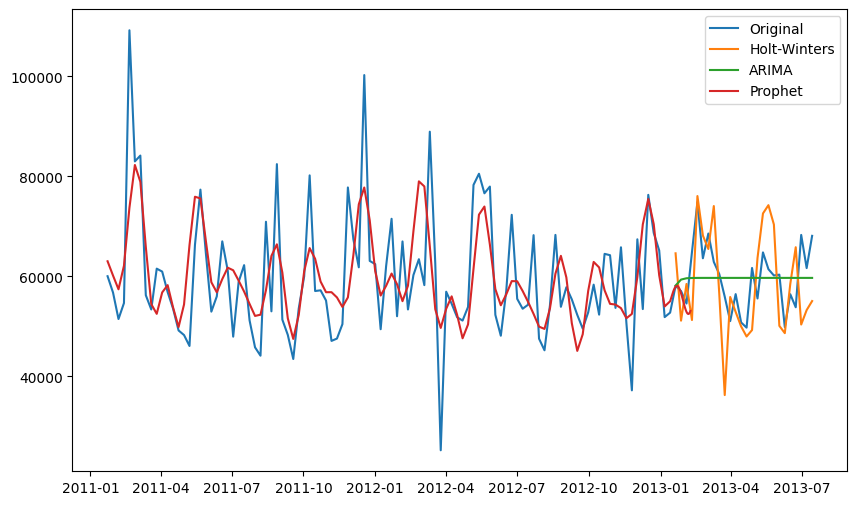

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_data, label='Original')
plt.plot(hw_predictions, label='Holt-Winters')
plt.plot(arima_predictions, label='ARIMA')
plt.plot(prophet_predictions['ds'], prophet_predictions['yhat'], label='Prophet')
plt.legend()
plt.show()

## Model Comparison Results


|Model|RMSE|
|---|---|
|Holt's Winter Exponential Smoothing|9283|
